In [1]:
# import python libraries

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns
from scipy import stats

In [2]:
# set plotting settings
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.size'] = 18
rcParams['figure.figsize'] = [6, 6]
#rcParams['figure.dpi'] = 300

In [3]:
# import spatial libraries
import geopandas as gpd
from shapely.geometry import Point,Polygon

In [4]:
# set seaborn style 
sns.set()
sns.set_style("whitegrid")

In [5]:
# load dataset

df = pd.read_csv("Italy_ppe.csv") 
df = df.drop(columns="Unnamed: 0")

# remove outliers top as in Alessandroni et al. 2014
df = df[(df["ppe"] > 0.001 ) & (df["ppe"] < 4)]  

# remove bottom 0.01%
df = df[df["ppe"] > df["ppe"].quantile(0.01) ] 

# calculate logarithm of ppe
df["log_ppe"] = np.log(df["ppe"])

df.head() 

,latitude,longitude,ppe,osm_id,road,timestamp,index_right,COD_REG,COD_PRO,COD_COM,NAME_COM,NAME_PRO,NAME_REG,log_ppe
0,42.823688,12.399041,0.249243,223578221,trunk,2018-03-20 13:11:32.790807,5800.0,10.0,54.0,54052.0,Todi,Perugia,Umbria,-1.389328
1,42.823504,12.399083,0.289182,223578221,trunk,2018-03-20 13:11:32.790807,5800.0,10.0,54.0,54052.0,Todi,Perugia,Umbria,-1.240700
2,42.825936,12.398878,0.253153,223578221,trunk,2018-03-20 13:11:32.790807,5800.0,10.0,54.0,54052.0,Todi,Perugia,Umbria,-1.373763
3,42.825747,12.398865,0.262400,223578221,trunk,2018-03-20 13:11:32.790807,5800.0,10.0,54.0,54052.0,Todi,Perugia,Umbria,-1.337885
4,42.825559,12.398853,0.543022,223578221,trunk,2018-03-20 13:11:32.790807,5800.0,10.0,54.0,54052.0,Todi,Perugia,Umbria,-0.610605


In [6]:
# selected roads - colors dictionary

roads = ["motorway", "trunk", "primary", "secondary", "tertiary",  "unclassified", "residential"] 
colors = ["blue", "darkorange", "green", "red",  "gray",  "violet", "purple"]

zip_iterator = zip(roads, colors)
col_dict = dict(zip_iterator)
print(col_dict)

{'motorway': 'blue', 'trunk': 'darkorange', 'primary': 'green', 'secondary': 'red', 'tertiary': 'gray', 'unclassified': 'violet', 'residential': 'purple'}


In [7]:
# create rank dictionary
zip_iterator = zip(roads, range(1,8))
rank_dict = dict(zip_iterator)
print(rank_dict)

{'motorway': 1, 'trunk': 2, 'primary': 3, 'secondary': 4, 'tertiary': 5, 'unclassified': 6, 'residential': 7}


In [8]:
# create type dictionary
zip_iterator = zip(roads, [1,1,2,2,2,2,3])
type_dict = dict(zip_iterator)
print(type_dict)

{'motorway': 1, 'trunk': 1, 'primary': 2, 'secondary': 2, 'tertiary': 2, 'unclassified': 2, 'residential': 3}


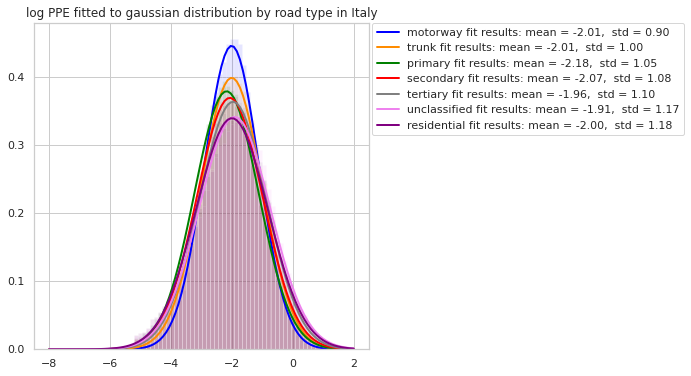

In [9]:
#plot gaussian fit of LOG PPE per road type in Italy

from scipy.stats import norm

stds_bf, means_bf = [],[]

stds, means = [],[]

for r in roads:
# Extract data in selected region
    data = df[df["road"]==r]["log_ppe"]
# Fit a normal distribution to the data:
    mean_bf, std_bf = norm.fit(data)
    means_bf.append(mean_bf)
    stds_bf.append(std_bf)
# calculate average and standard deviation
    means.append(data.mean())
    stds.append(data.std())    

# Plot the histogram.
    plt.hist(data, bins=50, density=True, alpha=0.1, color = col_dict[r])

# Plot the PDF.
    xmin, xmax = -8,2
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mean_bf, std_bf)
    l = str(r) + " fit results: mean = %.2f,  std = %.2f" % (mean_bf, std_bf)
    plt.plot(x, p, linewidth=2, label = l, color = col_dict[r])

plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
plt.title("log PPE fitted to gaussian distribution by road type in Italy")
#plt.savefig("log_ppe_fitted_norm_road_type_w_histo")
plt.show()

In [10]:
# add road type, rank and speed limit to calculated statistics
summary = pd.DataFrame(data = {"road_type" : roads, "mean" : means, "std" : stds, "mean_bf" : means_bf, "std_bf": stds_bf})
summary["type"] = [1,1,2,2,2,2,3]
summary["ranking"] = [1,2,3,4,5,6,7]
summary["maxmaxspeed"] = [130,110,90,90,90,70,50]
summary

,road_type,mean,std,mean_bf,std_bf,type,ranking,maxmaxspeed
0,motorway,-2.009122,0.896117,-2.009122,0.896116,1,1,130
1,trunk,-2.006509,1.001669,-2.006509,1.001668,1,2,110
2,primary,-2.175403,1.053866,-2.175403,1.053865,2,3,90
3,secondary,-2.068977,1.081575,-2.068977,1.081574,2,4,90
4,tertiary,-1.963811,1.098832,-1.963811,1.098831,2,5,90
5,unclassified,-1.909358,1.170455,-1.909358,1.170452,2,6,70
6,residential,-1.999694,1.176780,-1.999694,1.176776,3,7,50


In [11]:
#investigate linear correlation between mean of ppe and ranking

import statsmodels.api as sm
# mean log ppe vs max speed linear regression
x1 = summary[["ranking"]]
y = summary["mean_bf"]
# Add a constant
x = sm.add_constant(x1)
# Fit the model (OLS)
results = sm.OLS(y,x).fit()
# Print summary 
results.summary()

/home/christel/anaconda3/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                mean_bf   R-squared:                       0.158
Model:                            OLS   Adj. R-squared:                 -0.011
Method:                 Least Squares   F-statistic:                    0.9372
Date:                Tue, 12 Oct 2021   Prob (F-statistic):              0.377
Time:                        14:52:00   Log-Likelihood:                 8.5207
No. Observations:                   7   AIC:                            -13.04
Df Residuals:                       5   BIC:                            -13.15
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.0810      0.072    -29.050      0.000      -2.265      -1.897
ranking        0.0155      0.016      0.968      0.377      -0.026       0.057
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   1.759
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.884
Skew:                          -0.829   Prob(JB):                        0.643
Kurtosis:                       2.471   Cond. No.                         10.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [12]:
#investigate linear correlation between mean of ppe and ranking + road type

import statsmodels.api as sm
# mean log ppe vs max speed linear regression
x1 = summary[["ranking","type"]]
y = summary["mean"]
# Add a constant
x = sm.add_constant(x1)
# Fit the model (OLS)
results = sm.OLS(y,x).fit()
# Print summary 
results.summary()

/home/christel/anaconda3/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   mean   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.731
Method:                 Least Squares   F-statistic:                     9.148
Date:                Tue, 12 Oct 2021   Prob (F-statistic):             0.0322
Time:                        14:52:00   Log-Likelihood:                 13.933
No. Observations:                   7   AIC:                            -21.87
Df Residuals:                       4   BIC:                            -22.03
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.9221      0.055    -34.665      0.000      -2.076      -1.768
ranking        0.0791      0.018      4.277      0.013       0.028       0.130
type          -0.2224      0.058     -3.844      0.018      -0.383      -0.062
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   1.482
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.544
Skew:                           0.451   Prob(JB):                        0.762
Kurtosis:                       1.975   Cond. No.                         22.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

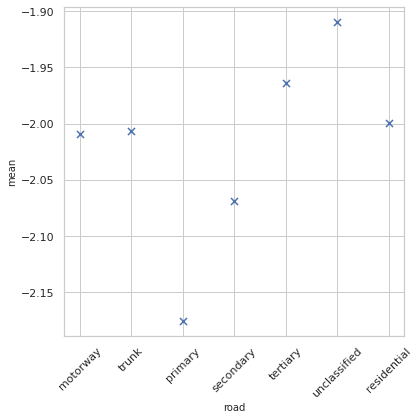

In [13]:
#plot mean of ppe vs road ranking

x1 = summary[["ranking","type"]]
rcParams['figure.figsize'] = [6, 6]
# Create a scatter plot
plt.scatter(roads, means_bf, marker = "x", s = 50)
plt.xticks(rotation=45)

# Label the axes
plt.xlabel('road', fontsize = 10)
plt.ylabel('mean', fontsize = 10)
#plt.title("std log ppe vs ranking linear regression", fontsize = 20)
plt.tight_layout()
#plt.savefig("fig6a")
plt.show()

In [14]:
#investigate linear correlation between std.dv. of ppe and ranking

import statsmodels.api as sm
# mean log ppe vs max speed linear regression
x1 = summary[["ranking"]]-1
y = stds_bf
# Add a constant
x = sm.add_constant(x1)
# Fit the model (OLS)
results = sm.OLS(y,x).fit()
# Print summary 
results.summary()

/home/christel/anaconda3/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.916
Method:                 Least Squares   F-statistic:                     66.04
Date:                Tue, 12 Oct 2021   Prob (F-statistic):           0.000458
Time:                        14:52:00   Log-Likelihood:                 16.156
No. Observations:                   7   AIC:                            -28.31
Df Residuals:                       5   BIC:                            -28.42
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9373      0.019     48.305      0.000       0.887       0.987
ranking        0.0437      0.005      8.126      0.000       0.030       0.058
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   1.733
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.694
Skew:                          -0.464   Prob(JB):                        0.707
Kurtosis:                       1.768   Cond. No.                         6.85
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

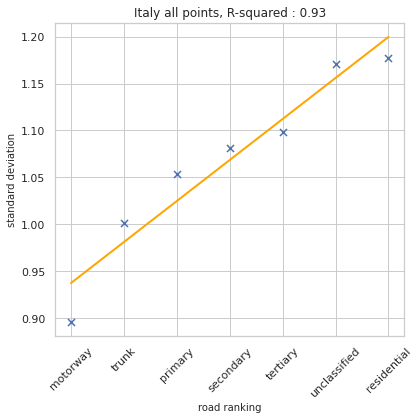

In [15]:
#plot std.dev. of ppe vs road ranking

plt.scatter(roads,  stds_bf, marker = "x", s = 50)
plt.xticks(rotation=45)

const = results.params[0]
ranking = results.params[1]
rsq = results.rsquared

yhat = ranking * np.asarray(x1) +  const

fig = plt.plot(x1,yhat, lw=2, c='orange', label ='regression line')
# Label the axes
plt.xlabel('road ranking', fontsize = 10)
plt.ylabel('standard deviation', fontsize = 10)
plt.title("Italy all points, R-squared : " + str(round(rsq,2)))
plt.tight_layout()
#plt.savefig("fig6b")
plt.show()

/home/christel/anaconda3/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


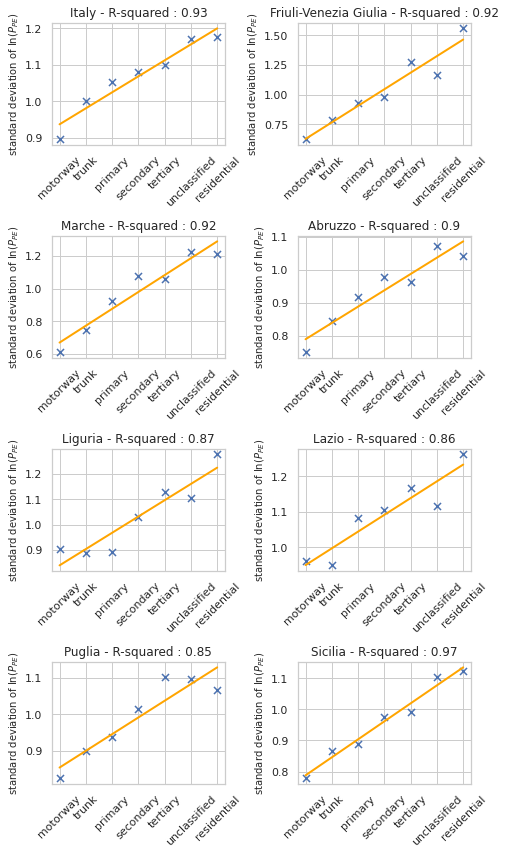

In [17]:
# calculate fitting and plot results for each of the selected regions
region_list = ["Friuli-Venezia Giulia", "Marche", "Abruzzo", "Liguria", "Lazio", "Puglia", "Sicilia"]
rcParams['figure.figsize'] = [7, 12]

fig = plt.figure()
columns = 2
rows = 4

fig.add_subplot(rows, columns, 1)

x1 = summary[["ranking"]]-1
y = stds_bf
# Add a constant
x = sm.add_constant(x1)
# Fit the model (OLS)
results = sm.OLS(y,x).fit()
# Print summary 
results.summary()

#extract parameters
const = results.params[0]
ranking = results.params[1]
rsq = results.rsquared

# Create a scatter plot
plt.scatter(roads,  stds_bf, marker = "x", s = 50)
plt.xticks(rotation=45)
# Plot regression line
yhat = ranking * np.asarray(x1) +  const
plt.plot(x1,yhat, lw=2, c="orange", label ="regression line")
    
plt.xlabel("", fontsize = 10)
plt.ylabel("standard deviation of ln($P_{PE}$)", fontsize = 10)
plt.title("Italy - R-squared : " + str(round(rsq,2)))
    
for index, region in enumerate(region_list):
    fig.add_subplot(rows, columns, index + 2)
    
    stds_r, means_r = [],[]

    for r in roads:
        # Extract data in selected region
        d = df[df["NAME_REG"] == region]
        data = d[d["road"]==r]["log_ppe"]
        # Fit a normal distribution to the data:
        mean, std = norm.fit(data)
        means_r.append(mean)
        stds_r.append(std)

    # mean log ppe vs max speed linear regression
    x1 = summary[["ranking"]]-1
    y = stds_r
    # Add a constant
    x = sm.add_constant(x1)
    # Fit the model (OLS)
    results = sm.OLS(y,x).fit()
    
    #extract parameters
    const = results.params[0]
    ranking = results.params[1]
    rsq = results.rsquared

    # Create a scatter plot
    plt.scatter(roads,  stds_r, marker = "x", s = 50)
    plt.xticks(rotation=45)
    # Plot regression line
    yhat = ranking * np.asarray(x1) +  const
    plt.plot(x1,yhat, lw=2, c="orange", label ="regression line")
    
    plt.xlabel("", fontsize = 10)
    plt.ylabel("standard deviation of ln($P_{PE}$)", fontsize = 10)
    plt.title(region + " - R-squared : " + str(round(rsq,2)))
    
plt.tight_layout(pad=1)

plt.savefig("fig6.svg", format='svg', transparent=True)

### ADD MAXSPEED TO DATASET

In [18]:
# load highway tag file
df_osm = pd.read_csv(r'Italy-osm-ways.csv')
df_osm = df_osm.drop(columns = "Unnamed: 0")
df_osm.head()

,id,tagkey,tagvalue
0,2954434,lit,no
1,2954434,ref,RA 9
2,2954434,name,Raccordo autostradale 9 di Benevento
3,2954434,toll,no
4,2954434,lanes,2


In [19]:
# add maxspeed values
max_speeds = df_osm[df_osm["tagkey"]=="maxspeed"].drop(columns = "tagkey").set_index("id", drop = True).rename(columns={"tagvalue": "maxspeed"})
max_speeds = max_speeds.replace("IT:rural",90)
max_speeds = max_speeds.replace("IT:urban",50)
max_speeds = max_speeds.replace("25 mph", 40)
max_speeds = max_speeds.replace("signals",np.NaN)
max_speeds = max_speeds.replace("30;90",np.NaN)
max_speeds = max_speeds.replace("90;50;30",np.NaN)
max_speeds = max_speeds.replace("50;30",np.NaN)
max_speeds = max_speeds.replace("70; 50",np.NaN)
max_speeds['maxspeed'] = pd.to_numeric(max_speeds['maxspeed'], errors='coerce')
max_speeds.head()

,maxspeed
id,
2954434,80.0
3211740,40.0
4589499,130.0
6009429,40.0
6059125,50.0


In [20]:
#df = df.drop(columns = "bridge")
df = df.set_index("osm_id", drop = True).join(max_speeds)
df.head()

,latitude,longitude,ppe,road,timestamp,index_right,COD_REG,COD_PRO,COD_COM,NAME_COM,NAME_PRO,NAME_REG,log_ppe,maxspeed
-3328048,41.749796,12.708312,0.214824,path,2018-08-25 05:37:41.031814,6183.0,12.0,58.0,58086.0,Rocca di Papa,Roma,Lazio,-1.537936,NaN
-3328048,41.749724,12.708504,0.279572,path,2018-08-25 05:37:41.031814,6183.0,12.0,58.0,58086.0,Rocca di Papa,Roma,Lazio,-1.274494,NaN
-3328048,41.749688,12.708712,0.279572,path,2018-08-25 05:37:41.031814,6183.0,12.0,58.0,58086.0,Rocca di Papa,Roma,Lazio,-1.274494,NaN
-3328048,41.749696,12.708922,0.242806,path,2018-08-25 05:37:41.031814,6183.0,12.0,58.0,58086.0,Rocca di Papa,Roma,Lazio,-1.415492,NaN
-3328048,41.749677,12.709130,0.247774,path,2018-08-25 05:37:41.031814,6183.0,12.0,58.0,58086.0,Rocca di Papa,Roma,Lazio,-1.395238,NaN


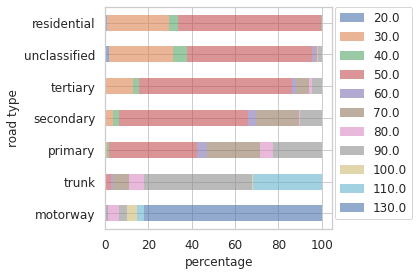

In [21]:
# calculate percentage of points having a given speed limit per road type in SRS data
rcParams['figure.figsize'] = [6, 4]

speeds = [20,30,40,50,60,70,80,90,100,110,130]
# max speed by road type

d = df[(df["road"].isin(roads)) & (df["maxspeed"].isin(speeds))].groupby(['road','maxspeed']).size()

d = d.unstack(level=1)
d = d.div(d.sum(axis=1), axis=0).mul(100).round(2)
d = d.reindex(roads)

fig, ax = plt.subplots()
d.plot.barh(ax=ax,stacked = True,  edgecolor='none', alpha = 0.6)

ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.set_xlabel('percentage', size=12)
ax.set_ylabel('road type', size=12)

ax.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0., fontsize = 12)

plt.tight_layout()

plt.savefig("fig7.svg", format='svg', transparent=True)

plt.show()

In [22]:
#df = df[df["road"].isin(roads)]
#df_mean = df.groupby(["road","maxspeed"]).log_ppe.mean().round(2)
#df_mean = df_mean.unstack(level=1)
#df_mean = df_mean.reindex(roads)
#df_mean

#### URBAN ROADS, speed limit 50 km/h


In [23]:
# define a function to calculate the confidence interval for the mean

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), stats.sem(a)
    h = se * stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m - h, m + h, h

In [24]:
# select urban roads (no motorway of trunk)
urban_roads = roads[2:]
summary50 = pd.DataFrame(urban_roads, columns =["road"])

In [25]:
# extract roads having speed limit 50 km/h
speed = 50 

means = []
lowerb = []
upperb = []
error = []
for r in urban_roads:
    data = df[(df["road"]==r) & (df["maxspeed"]==50)]["log_ppe"]
    m, l, u, h = mean_confidence_interval(data)
    means.append(m)
    lowerb.append(l)
    upperb.append(u)
    error.append(h)

summary50["mean"] = means
summary50["lowerb"] = lowerb
summary50["upperb"] = upperb
summary50["error"] = error
summary50

,road,mean,lowerb,upperb,error
0,primary,-2.158347,-2.165119,-2.151575,0.006772
1,secondary,-2.036650,-2.043203,-2.030097,0.006553
2,tertiary,-2.012365,-2.020443,-2.004286,0.008078
3,unclassified,-1.919352,-1.941244,-1.897460,0.021892
4,residential,-1.937814,-1.958286,-1.917341,0.020472


In [26]:
#investigate linear correlation between mean of ppe and ranking in urban roads (speed limit = 50km/h)

import statsmodels.api as sm
# mean log ppe vs max speed linear regression
x1 = np.arange(5)
y = summary50["mean"]
# Add a constant
x = sm.add_constant(x1)
# Fit the model (OLS)
results = sm.OLS(y,x).fit()
# Print summary 
results.summary()

/home/christel/anaconda3/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   mean   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     18.97
Date:                Tue, 12 Oct 2021   Prob (F-statistic):             0.0224
Time:                        14:52:18   Log-Likelihood:                 10.209
No. Observations:                   5   AIC:                            -16.42
Df Residuals:                       3   BIC:                            -17.20
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.1246      0.031    -67.652      0.000      -2.225      -2.025
x1             0.0558      0.013      4.355      0.022       0.015       0.097
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   2.481
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.624
Skew:                          -0.005   Prob(JB):                        0.732
Kurtosis:                       1.270   Cond. No.                         4.74
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

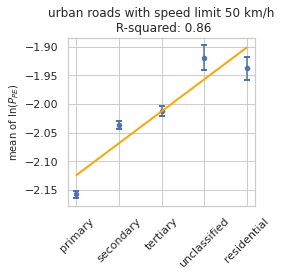

In [27]:
# plot mean vs road ranking in urban roads (speed limit 50 km/h)
rcParams['figure.figsize'] = [4, 4]
plt.scatter(urban_roads, summary50["mean"], marker = "o", s = 20)
plt.errorbar(urban_roads, summary50["mean"], yerr = summary50["error"], ls='none', capsize=3, capthick=2)
plt.xticks(rotation=45)

const = results.params[0]
ranking = results.params[1]
rsq = results.rsquared

yhat = ranking * np.asarray(x1) + const
fig = plt.plot(x1,yhat, lw=2, c='orange', label ='regression line')
# Label the axes
plt.xlabel("", fontsize = 10)
plt.ylabel("mean of ln($P_{PE}$)", fontsize = 10)
plt.title("urban roads with speed limit 50 km/h\n R-squared: " + str(round(rsq,2)))
plt.tight_layout()

plt.savefig("fig8a.svg", format='svg', transparent=True)

plt.show()

In [28]:
# calculate mean of ppe with confidence interval in urban roads with speed limit = 40 km/h
summary40 = pd.DataFrame(urban_roads, columns =["road"])

speed = 40 

means = []
lowerb = []
upperb = []
error = []
for r in urban_roads:
    data = df[(df["road"]==r) & (df["maxspeed"]==40)]["log_ppe"]
    m, l, u, h = mean_confidence_interval(data)
    means.append(m)
    lowerb.append(l)
    upperb.append(u)
    error.append(h)

summary40["mean"] = means
summary40["lowerb"] = lowerb
summary40["upperb"] = upperb
summary40["error"] = error
summary40

,road,mean,lowerb,upperb,error
0,primary,-2.423517,-2.463769,-2.383265,0.040252
1,secondary,-1.966449,-1.997355,-1.935543,0.030906
2,tertiary,-1.846350,-1.886561,-1.806138,0.040211
3,unclassified,-1.882854,-1.960180,-1.805527,0.077327
4,residential,-1.629947,-1.699679,-1.560215,0.069732


In [29]:
#investigate linear correlation between mean of ppe and ranking in urban roads (speed limit = 40km/h)
import statsmodels.api as sm
# mean log ppe vs max speed linear regression
x1 = np.arange(5)
y = summary40["mean"]
# Add a constant
x = sm.add_constant(x1)
# Fit the model (OLS)
results = sm.OLS(y,x).fit()
# Print summary 
results.summary()

/home/christel/anaconda3/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   mean   R-squared:                       0.816
Model:                            OLS   Adj. R-squared:                  0.754
Method:                 Least Squares   F-statistic:                     13.28
Date:                Tue, 12 Oct 2021   Prob (F-statistic):             0.0356
Time:                        14:52:19   Log-Likelihood:                 3.8389
No. Observations:                   5   AIC:                            -3.678
Df Residuals:                       3   BIC:                            -4.459
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.2840      0.112    -20.341      0.000      -2.641      -1.927
x1             0.1671      0.046      3.645      0.036       0.021       0.313
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   2.143
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.549
Skew:                           0.112   Prob(JB):                        0.760
Kurtosis:                       1.392   Cond. No.                         4.74
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

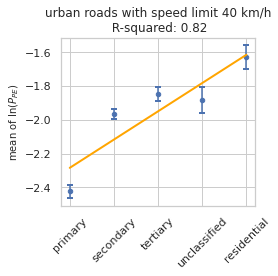

In [30]:
# plot mean vs road ranking in urban roads (speed limit 40 km/h)
rcParams['figure.figsize'] = [4, 4]
plt.scatter(urban_roads, summary40["mean"], marker = "o", s = 20)
plt.errorbar(urban_roads, summary40["mean"], yerr = summary40["error"], ls='none', capsize=3, capthick=2)
plt.xticks(rotation=45)

const = results.params[0]
ranking = results.params[1]
rsq = results.rsquared

yhat = ranking * np.asarray(x1) + const
fig = plt.plot(x1,yhat, lw=2, c='orange', label ='regression line')
# Label the axes
plt.xlabel("", fontsize = 10)
plt.ylabel("mean of ln($P_{PE}$)", fontsize = 10)
plt.title("urban roads with speed limit 40 km/h\n R-squared: " + str(round(rsq,2)))
plt.tight_layout()

plt.savefig("fig8b.svg", format='svg', transparent=True)

plt.show()

### SPEED LIMIT and PPE

In [31]:
#extract motorway points
mdf = df[df["road"]== "motorway"]
# consider maximum speed limit and decreased speed limits
speeds = [90,110,130]

In [32]:
# calculate the average ppe per speed limit
means = np.exp(mdf.groupby("maxspeed").log_ppe.mean()).round(3)
means = means[means.index.isin(speeds)].reset_index()
means = means.rename(columns = {"log_ppe": "geo_mean"})
means

,maxspeed,geo_mean
0,90.0,0.195
1,110.0,0.148
2,130.0,0.131


In [33]:
# calculate 95% confidence interval 
lowerb = []
upperb = []

for s in speeds:
    data = mdf[mdf["maxspeed"]==s]["log_ppe"]
    m, l, u, h = mean_confidence_interval(data)
    lowerb.append(np.exp(l))
    upperb.append(np.exp(u))
    
means["lowerb"] = lowerb
means["upperb"] = upperb

In [34]:
means

,maxspeed,geo_mean,lowerb,upperb
0,90.0,0.195,0.192603,0.196860
1,110.0,0.148,0.145884,0.150428
2,130.0,0.131,0.130822,0.131456


In [35]:
# assign a colour to each speed
speeds = [90,110,130]
speed_colors = ["#5975A4","#CC8963","#5F9E6E"]
zip_iterator = zip(speeds, speed_colors)
speed_dict = dict(zip_iterator)
print(speed_dict)

{90: '#5975A4', 110: '#CC8963', 130: '#5F9E6E'}


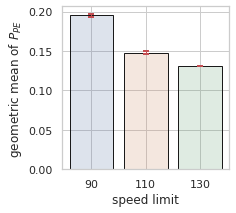

In [36]:
# plot geometric mean and interval of confidence
rcParams['figure.figsize'] = [3, 3]
x = speeds
y = means["geo_mean"]

# calculating error
y_errormin = means["geo_mean"] - means["lowerb"]
y_errormax = means["upperb"] - means["geo_mean"]
y_error = [y_errormin, y_errormax]

plt.bar(x, y, color = speed_colors, alpha = 0.2, width = 16)
plt.bar(x, y, yerr=y_error, width = 16,
        edgecolor='k', color='None', lw = 1, error_kw=dict(ecolor='r', lw=1, capsize=3, capthick=2))
plt.xlabel("speed limit")
plt.ylabel("geometric mean of $P_{PE}$")
plt.xticks([90,110,130])

plt.savefig("fig13a.svg", format='svg', transparent=True)

In [37]:
# define a function to create speed limit label for graphs
from matplotlib.lines import Line2D
def make_label(col_dict) :
    names = []
    lines = []
    for key in col_dict:
        names.append(str(key))
        lines.append(Line2D([0], [0], color=col_dict[key], lw=4))
    return names, lines

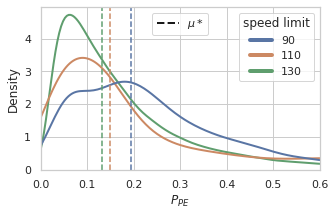

In [38]:
# plot ppe distribution and geometric mean per speed limit in motorways
rcParams['figure.figsize'] = [5, 3]

d = mdf[mdf["maxspeed"].isin(speeds)]
sns.kdeplot(data = d, x="ppe", hue="maxspeed", common_norm=False, palette = speed_colors, gridsize=1000, hue_order= speeds, linewidth = 2)
plt.xlim([0, 0.6])

names, lines = make_label(dict((k, speed_dict[k]) for k in speeds))
legend1 = plt.legend(lines, names, title = "speed limit", loc = 1) 

for i, s in enumerate(speeds):
    x1 = means["geo_mean"].iloc[i]
    plt.axvline(x = x1, ls = "--", color = speed_dict[s])

lines = []
lines.append(Line2D([0], [0], color="k", linewidth=2, linestyle='--')) 
legend2 = plt.legend(lines, ["$\mu*$"],loc = 9)

plt.xlabel("$P_{PE}$")
plt.gca().add_artist(legend1)  
plt.savefig("fig13b.svg", format='svg', transparent=True)

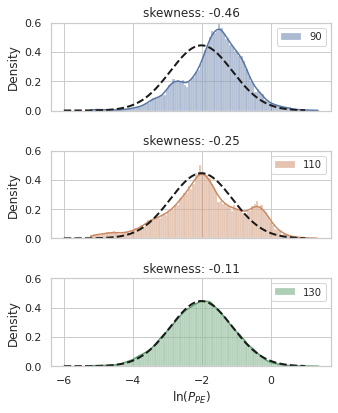

In [39]:
# plot distribution of ln(ppe) per speed limit in motorways
from scipy.stats import norm

rcParams['figure.figsize'] = [5, 6]
f, ax_list = plt.subplots(len(speeds), sharex=True)
x = np.linspace(-6, 1, 1000)
p = norm.pdf(x, summary["mean"].iloc[0], summary["std"].iloc[0])

for index,speed in enumerate(speeds):
    data = mdf[mdf["maxspeed"]==speed]["log_ppe"]
    sns.histplot(data, ax=ax_list[index], color=speed_dict[speed], bins=100, 
                 kde = True, alpha = .5, label = speed, stat = "density")
    ax_list[index].legend(fontsize = 10)
    ax_list[index].set_ylim([0,0.6])
    ax_list[index].plot(x, p, 'k', linewidth=2, ls = "--")
    s = round(data.skew(),2)
    ax_list[index].set_title("skewness: " + str(s) )

plt.tight_layout(pad=1.5)
plt.xlabel("ln($P_{PE}$)")
plt.savefig("fig14.svg", format='svg', transparent=True)
plt.show()

In [40]:
# define function to apply vehicle speed normalization
def normalize(row):
    if row["maxspeed"] == 130:
        return row["ppe"]
    if row["maxspeed"] == 110:
        return row["ppe"] + row["ppe"]*0.16
    if row["maxspeed"] == 90:
        return row["ppe"] + row["ppe"]*0.32
    return np.nan

In [41]:
# apply vehicle speed normalization
mdfn = df[df["road"]== "motorway"][["ppe","log_ppe","maxspeed"]]
mdfn["normalized"] = mdfn.apply (lambda row: normalize(row), axis=1)
mdfn["log_normalized"] = np.log(mdfn["normalized"])

In [42]:
# calculate normalized geometric mean per speed limit
meansn = np.exp(mdfn.groupby("maxspeed").log_normalized.mean()).round(2)
meansn = meansn[meansn.index.isin([90,110,130])].reset_index()
meansn = meansn.rename(columns = {"log_normalized": "geo_mean"})
meansn

,maxspeed,geo_mean
0,90.0,0.26
1,110.0,0.17
2,130.0,0.13


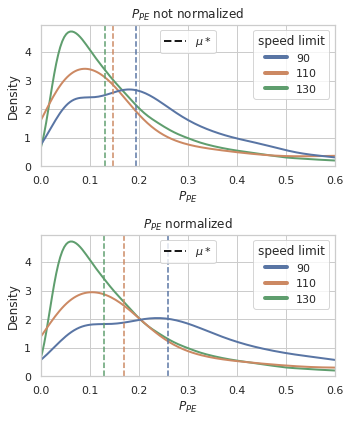

In [43]:
# plot distribution of ln(ppe) per speed limit in motorways, normalized and non
rcParams['figure.figsize'] = [5, 6]
fig = plt.figure()

# PLOT 1
fig.add_subplot(2, 1, 1)
d = mdf[mdf["maxspeed"].isin(speeds)]
sns.kdeplot(data = d, x="ppe", hue="maxspeed", common_norm=False, palette = speed_colors, gridsize=1000, hue_order= speeds, linewidth = 2)
plt.xlim([0, 0.6])

names, lines = make_label(dict((k, speed_dict[k]) for k in speeds))
legend1 = plt.legend(lines, names, title = "speed limit", loc = 1) 

for i, s in enumerate(speeds):
    x1 = means["geo_mean"].iloc[i]
    plt.axvline(x = x1, ls = "--", color = speed_dict[s])

lines = []
lines.append(Line2D([0], [0], color="k", linewidth=2, linestyle='--')) 
legend2 = plt.legend(lines, ["$\mu*$"],loc = 9)

plt.gca().add_artist(legend1)  

plt.xlabel("$P_{PE}$")
plt.title("$P_{PE}$ not normalized")

# PLOT 2 (normalized)
fig.add_subplot(2, 1, 2)
d = mdfn[mdfn["maxspeed"].isin(speeds)]
sns.kdeplot(data = d, x="normalized", hue="maxspeed", common_norm=False, palette = speed_colors, gridsize=1000, hue_order= speeds, linewidth = 2)
plt.xlim([0, 0.6])

names, lines = make_label(dict((k, speed_dict[k]) for k in speeds))
legend1 = plt.legend(lines, names, title = "speed limit", loc = 1) 

for i, s in enumerate(speeds):
    x1 = meansn["geo_mean"].iloc[i]
    plt.axvline(x = x1, ls = "--", color = speed_dict[s])

lines = []
lines.append(Line2D([0], [0], color="k", linewidth=2, linestyle='--')) 
legend2 = plt.legend(lines, ["$\mu*$"],loc = 9)

plt.gca().add_artist(legend1)  

plt.xlabel("$P_{PE}$")
plt.title("$P_{PE}$ normalized")

plt.tight_layout(pad=1)

plt.savefig("fig25.svg", format='svg', transparent=True)

In [44]:
# assign colour to max speed points
mdf["speed_color"] = mdf["maxspeed"].map(speed_dict)
# assign colour black to points with unknown speed limit
mdf["speed_color"] = mdf["speed_color"].replace(np.nan, "#000000")

<ipython-input-44-cdc5318bce51>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mdf["speed_color"] = mdf["maxspeed"].map(speed_dict)
<ipython-input-44-cdc5318bce51>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mdf["speed_color"] = mdf["speed_color"].replace(np.nan, "#000000")


In [45]:
# create geometry points
geometry=[Point(xy) for xy in zip(mdf["longitude"], mdf["latitude"])] 
# create geodataframe
mdfg = gpd.GeoDataFrame(mdf, crs="EPSG:4326", geometry=geometry) 
mdfg.head()

,latitude,longitude,ppe,road,timestamp,index_right,COD_REG,COD_PRO,COD_COM,NAME_COM,NAME_PRO,NAME_REG,log_ppe,maxspeed,speed_color,geometry
-3306416,45.507056,9.618942,0.021378,motorway,2018-11-14 13:17:22.54175,2238.0,3.0,16.0,16219.0,Treviglio,Bergamo,Lombardia,-3.845382,NaN,#000000,POINT (9.61894 45.50706)
-3306416,45.507139,9.619179,0.021922,motorway,2018-11-14 13:17:22.54175,2238.0,3.0,16.0,16219.0,Treviglio,Bergamo,Lombardia,-3.820250,NaN,#000000,POINT (9.61918 45.50714)
-3306416,45.506974,9.618706,0.040609,motorway,2018-08-28 04:18:32.34548,2238.0,3.0,16.0,16219.0,Treviglio,Bergamo,Lombardia,-3.203758,NaN,#000000,POINT (9.61871 45.50697)
-3306416,45.505598,9.494273,0.038818,motorway,2019-01-16 18:04:48.468966,1488.0,3.0,15.0,15224.0,Truccazzano,Milano,Lombardia,-3.248881,NaN,#000000,POINT (9.49427 45.50560)
-3306416,45.505602,9.494524,0.055841,motorway,2019-01-16 18:04:48.468966,1488.0,3.0,15.0,15224.0,Truccazzano,Milano,Lombardia,-2.885251,NaN,#000000,POINT (9.49452 45.50560)


In [46]:
# read regional borders shape file
italy_regions = gpd.read_file('geojson_italy_cities/italy_all_regions.geojson')

In [47]:
# assign colour to points according to ppe as in SRS visualization tool
ppe_points = [0, 0.3, 0.5, 0.7, 1, 1.7, 4]
ppe_colors = ["#78ad4d", "#e9e25b", "#f3a65a", "#fd6959", "#ca5755", "#76504f"]
bins = pd.cut(mdfg["ppe"], ppe_points) 
mdfg["bins"] = bins
ppe_ranges = list(mdfg["bins"].sort_values().unique())

In [48]:
# assign colour to ppe interval
zip_iterator = zip(ppe_ranges, ppe_colors)
ppe_dict = dict(zip_iterator)
print(ppe_dict)

{Interval(0.0, 0.3, closed='right'): '#78ad4d', Interval(0.3, 0.5, closed='right'): '#e9e25b', Interval(0.5, 0.7, closed='right'): '#f3a65a', Interval(0.7, 1.0, closed='right'): '#fd6959', Interval(1.0, 1.7, closed='right'): '#ca5755', Interval(1.7, 4.0, closed='right'): '#76504f'}


In [49]:
# add corresponding colour to dataset
mdfg['color_ppe']= mdfg['bins'].map(ppe_dict)
mdfg.head()

,latitude,longitude,ppe,road,timestamp,index_right,COD_REG,COD_PRO,COD_COM,NAME_COM,NAME_PRO,NAME_REG,log_ppe,maxspeed,speed_color,geometry,bins,color_ppe
-3306416,45.507056,9.618942,0.021378,motorway,2018-11-14 13:17:22.54175,2238.0,3.0,16.0,16219.0,Treviglio,Bergamo,Lombardia,-3.845382,NaN,#000000,POINT (9.61894 45.50706),"(0.0, 0.3]",#78ad4d
-3306416,45.507139,9.619179,0.021922,motorway,2018-11-14 13:17:22.54175,2238.0,3.0,16.0,16219.0,Treviglio,Bergamo,Lombardia,-3.820250,NaN,#000000,POINT (9.61918 45.50714),"(0.0, 0.3]",#78ad4d
-3306416,45.506974,9.618706,0.040609,motorway,2018-08-28 04:18:32.34548,2238.0,3.0,16.0,16219.0,Treviglio,Bergamo,Lombardia,-3.203758,NaN,#000000,POINT (9.61871 45.50697),"(0.0, 0.3]",#78ad4d
-3306416,45.505598,9.494273,0.038818,motorway,2019-01-16 18:04:48.468966,1488.0,3.0,15.0,15224.0,Truccazzano,Milano,Lombardia,-3.248881,NaN,#000000,POINT (9.49427 45.50560),"(0.0, 0.3]",#78ad4d
-3306416,45.505602,9.494524,0.055841,motorway,2019-01-16 18:04:48.468966,1488.0,3.0,15.0,15224.0,Truccazzano,Milano,Lombardia,-2.885251,NaN,#000000,POINT (9.49452 45.50560),"(0.0, 0.3]",#78ad4d


In [50]:
#create a legend for maps
import matplotlib.patches as mpatches
ppe_legend = []
for key in ppe_dict:
    ppe_legend.append(mpatches.Patch(color=ppe_dict[key], label=key))

In [51]:
# generate speed limit legend
import matplotlib.patches as mpatches
speed_legend = []
for key in speed_dict:
    speed_legend.append(mpatches.Patch(color=speed_dict[key], label=str(key) + " km/h"))
speed_legend.append(mpatches.Patch(color="k", label="N/A"))
speed_legend

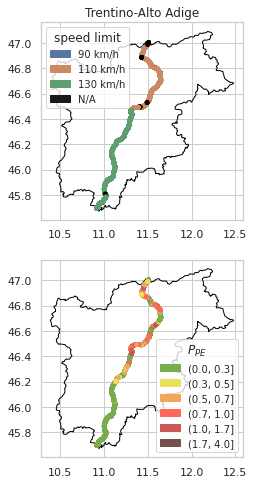

In [52]:
#plot ppe and speed limit in Trentino-Alto Adige motorways

rcParams['figure.figsize'] = [5, 8]
#rcParams['figure.dpi'] = 600
region = "Trentino-Alto Adige"

f, (ax1, ax2) = plt.subplots(2, 1, sharey=True)

# PLOT 1
italy_regions[italy_regions["NOME_REG"]== region].plot(ax = ax1, facecolor='none', edgecolor='black', linewidth=1) 
#alpha = 0.2, color = "grey",
 
data = mdfg[mdfg["NAME_REG"]== region]
data.plot(ax = ax1, color=data.speed_color, markersize = 12)
    
ax1.legend(handles = speed_legend, title = "speed limit", fontsize= 10, title_fontsize = 12)
 
italy_regions[italy_regions["NOME_REG"]== region].plot(ax = ax2, facecolor='none', edgecolor='black', linewidth=1) 
#alpha = 0.2, color = "grey",
 
data = mdfg[mdfg["NAME_REG"]== region]
data.plot(ax = ax2, color=data.color_ppe, markersize = 12)
    
ax2.legend(handles = ppe_legend, title = "$P_{PE}$", fontsize= 10, title_fontsize = 12)

ax1.set_title("Trentino-Alto Adige")

plt.savefig("fig15")
#plt.savefig("fig15.svg", format='svg', transparent=True)
plt.show()

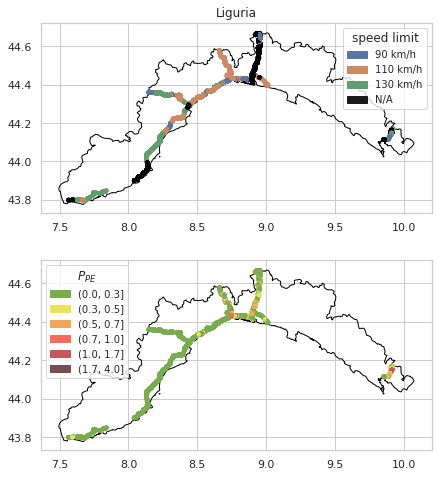

In [53]:
#plot ppe and speed limit in Liguria motorways
rcParams['figure.figsize'] = [7, 8]
#rcParams['figure.dpi'] = 600
region = "Liguria"

f, (ax1, ax2) = plt.subplots(2, 1, sharey=True)

# PLOT 1
italy_regions[italy_regions["NOME_REG"]== region].plot(ax = ax1, facecolor='none', edgecolor='black', linewidth=1) 
#alpha = 0.2, color = "grey",
 
data = mdfg[mdfg["NAME_REG"]== region]
data.plot(ax = ax1, color=data.speed_color, markersize = 12)
    
ax1.legend(handles = speed_legend, title = "speed limit", fontsize= 10, title_fontsize = 12)
 
italy_regions[italy_regions["NOME_REG"]== region].plot(ax = ax2, facecolor='none', edgecolor='black', linewidth=1) 
#alpha = 0.2, color = "grey",
 
data = mdfg[mdfg["NAME_REG"]== region]
data.plot(ax = ax2, color=data.color_ppe, markersize = 12)
    
ax2.legend(handles = ppe_legend, title = "$P_{PE}$", fontsize= 10, title_fontsize = 12)

ax1.set_title("Liguria")

plt.savefig("fig16")

#plt.savefig("fig16.svg", format='svg', transparent=True)
plt.show()

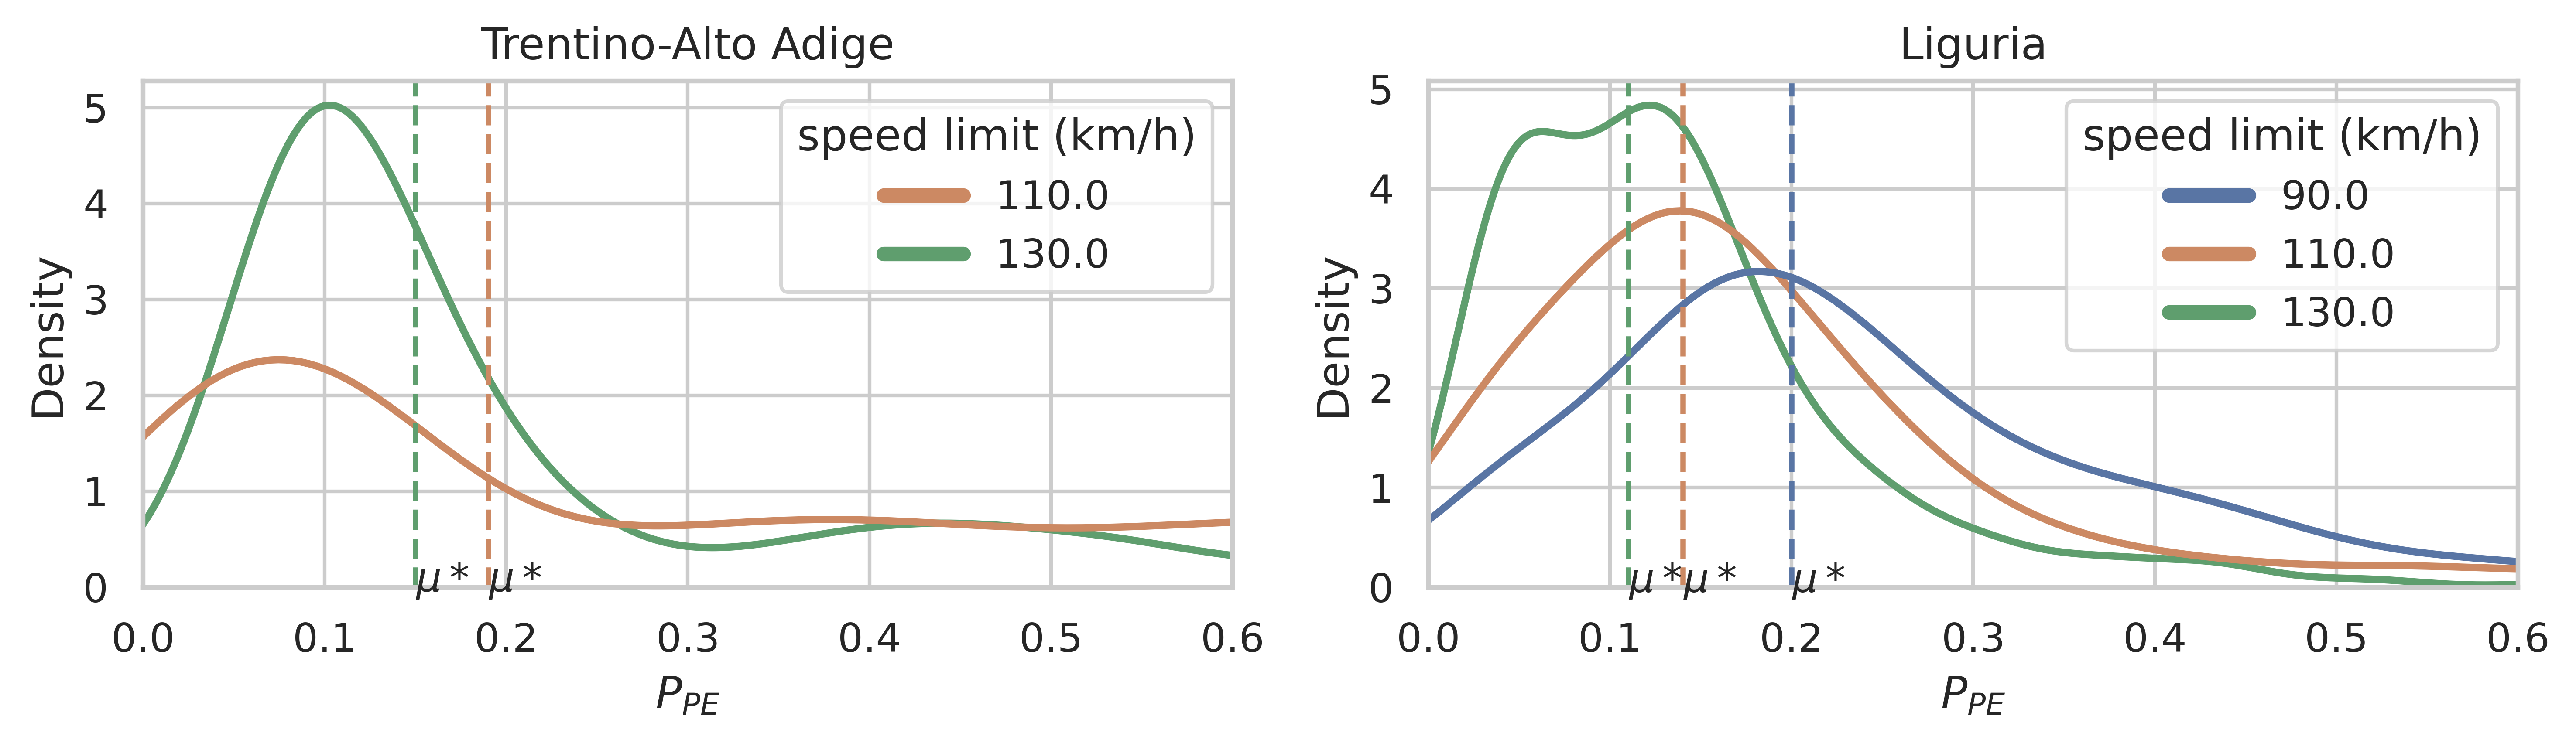

In [42]:
#ppe distribution and geometric mean in motorways, selected regions
rcParams['figure.figsize'] = [10, 3]
#rcParams['figure.dpi'] = 600
f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)

# REGION 3
region = "Trentino-Alto Adige"
d = mdf[(mdf["maxspeed"].isin(speeds)) & (mdf["NAME_REG"]==region)]
sns.kdeplot(ax = ax1, data = d, x="ppe", hue="maxspeed", common_norm=False, palette = speed_colors, gridsize=1000, hue_order= speeds, linewidth = 2)

ax1.set(xlim=(0, 0.6))

m = np.exp(d.groupby("maxspeed").log_ppe.mean()).round(2)
m = m[m.index.isin([90,110,130])].reset_index()
zip_iterator = zip(m["maxspeed"], m["log_ppe"])
d = dict(zip_iterator) 

names, lines = make_label(dict((k, speed_dict[k]) for k in d.keys()))
ax1.legend(lines, names, title = "speed limit (km/h)" ) 

for s in d.keys():
    x1 = d[s]
    ax1.axvline(x = x1, ls = "--", color = speed_dict[s])
    ax1.text(x = x1, y = -0.05, s = "$\mu*$", fontsize = 11)

ax1.set_xlabel("$P_{PE}$")
ax1.set_title(region)

# REGION 2
region = "Liguria"
d = mdf[(mdf["maxspeed"].isin(speeds)) & (mdf["NAME_REG"]==region)]
sns.kdeplot(ax = ax2, data = d, x="ppe", hue="maxspeed", common_norm=False, palette = speed_colors, gridsize=1000, hue_order= speeds, linewidth = 2)

m = np.exp(d.groupby("maxspeed").log_ppe.mean()).round(2)
m = m[m.index.isin([90,110,130])].reset_index()
zip_iterator = zip(m["maxspeed"], m["log_ppe"])
d = dict(zip_iterator) 

names, lines = make_label(dict((k, speed_dict[k]) for k in d.keys()))
ax2.legend(lines, names, title = "speed limit (km/h)") 

for s in d.keys():
    x1 = d[s]
    ax2.axvline(x = x1, ls = "--", color = speed_dict[s])
    ax2.text(x = x1, y = -0.05, s = "$\mu*$", fontsize = 11)

ax2.set_xlabel("$P_{PE}$")  
ax2.set_title(region)
plt.tight_layout()
plt.savefig("fig17")

#plt.savefig("fig17.svg", format='svg', transparent=True)

In [55]:
# geometric mean of ppe per road type and speed limit
np.exp(df[df["road"].isin(roads) & df["maxspeed"].isin([30,50,70,90])].groupby(["road","maxspeed"]).log_ppe.mean()).round(2).unstack(level = 1)

maxspeed,30.0,50.0,70.0,90.0
road,,,,
motorway,0.10,0.16,0.12,0.19
primary,0.11,0.12,0.12,0.11
residential,0.10,0.14,0.04,NaN
secondary,0.18,0.13,0.12,0.11
tertiary,0.15,0.13,0.13,0.07
trunk,0.16,0.13,0.15,0.14
unclassified,0.19,0.15,0.10,0.14


In [56]:
# number of mapped points per road type and speed limit
df[df["road"].isin(roads) & df["maxspeed"].isin([30,50,70,90])].groupby(["road","maxspeed"]).log_ppe.count().unstack(level = 1)

maxspeed,30.0,50.0,70.0,90.0
road,,,,
motorway,173.0,398.0,3064.0,24544.0
primary,1810.0,98126.0,59433.0,54240.0
residential,5644.0,13093.0,40.0,NaN
secondary,5846.0,104009.0,34299.0,17397.0
tertiary,13917.0,77644.0,6341.0,5116.0
trunk,83.0,7374.0,24685.0,161703.0
unclassified,5642.0,10983.0,149.0,275.0


In [57]:
# extraurban roads (not enough mapped points in unclassified)
extraurban = ["trunk","primary","secondary","tertiary"]

In [58]:
# compare geometric mean of ppe in extra urban roads at 70 and 90 km/h speed limits
stats_s = np.exp(df[df["road"].isin(extraurban) & df["maxspeed"].isin([70,90])].groupby(["road","maxspeed"]).log_ppe.mean()).round(4).unstack(level = 1)
stats_s = stats_s.reindex(extraurban)
stats_s

maxspeed,70.0,90.0
road,,
trunk,0.1451,0.1400
primary,0.1162,0.1146
secondary,0.1164,0.1107
tertiary,0.1279,0.0739


In [59]:
# calculate corresponding confidence interval
lowerb = []
upperb = []
for r in extraurban:
    data = df[(df["road"]==r) & (df["maxspeed"]==90)]["log_ppe"]
    m, l, u, h = mean_confidence_interval(data)
    lowerb.append(np.exp(l))
    upperb.append(np.exp(u))
    
stats_s["lowerb90"] = lowerb
stats_s["upperb90"] = upperb
stats_s

maxspeed,70.0,90.0,lowerb90,upperb90
road,,,,
trunk,0.1451,0.1400,0.139381,0.140719
primary,0.1162,0.1146,0.113623,0.115646
secondary,0.1164,0.1107,0.109071,0.112391
tertiary,0.1279,0.0739,0.071882,0.076018


In [61]:
lowerb = []
upperb = []
for r in extraurban:
    data = df[(df["road"]==r) & (df["maxspeed"]==70)]["log_ppe"]
    m, l, u, h = mean_confidence_interval(data)
    lowerb.append(np.exp(l))
    upperb.append(np.exp(u))
    
stats_s["lowerb70"] = lowerb
stats_s["upperb70"] = upperb
stats_s

maxspeed,70.0,90.0,lowerb90,upperb90,lowerb70,upperb70
road,,,,,,
trunk,0.1451,0.1400,0.139381,0.140719,0.143342,0.146933
primary,0.1162,0.1146,0.113623,0.115646,0.115226,0.117224
secondary,0.1164,0.1107,0.109071,0.112391,0.115136,0.117724
tertiary,0.1279,0.0739,0.071882,0.076018,0.124867,0.131047


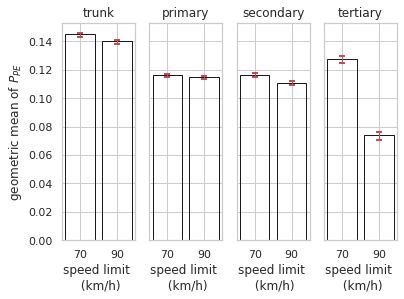

In [67]:
# compare geometric mean of ppe in extra-urban roads at 70 and 90 km/h speed limit
rcParams['figure.figsize'] = [6, 4]

f, ax_list = plt.subplots(1, len(extraurban), sharey=True)

for i,r in enumerate(extraurban):
    # plot bars
    x = ["70","90"]
    y = [stats_s.iat[i,0], stats_s.iat[i,1]]
    
    y_errormin = [stats_s.iat[i,0] - stats_s.iat[i,4], stats_s.iat[i,5] - stats_s.iat[i,0]]
    y_errormax = [stats_s.iat[i,1] - stats_s.iat[i,2], stats_s.iat[i,3] - stats_s.iat[i,1]]
    y_error = [y_errormin, y_errormax]
    
    ax_list[i].bar(x, y, yerr=y_error, edgecolor='k', color='None', lw = 1, error_kw=dict(ecolor='r', lw=1, capsize=3, capthick=2))
    ax_list[i].set_title(r)
    ax_list[i].set_xlabel("speed limit \n (km/h)")

ax_list[0].set_ylabel("geometric mean of $P_{PE}$")
#plt.errorbar(x, y, yerr=y_error, color="r", fmt='o') 

plt.savefig("fig20.svg", format='svg', transparent=True)

In [68]:
# apply t-test to verify differences are significant
for r in extraurban:
    d1_ = df[(df["road"]==r) & (df["maxspeed"]==70)]["log_ppe"]
    d2_ = df[(df["road"]==r) & (df["maxspeed"]==90)]["log_ppe"]
    s, pv = stats.ttest_ind(d1_, d2_, equal_var=False)
    print(r + " p-value = " + str(round(pv,3)))

trunk p-value = 0.0
primary p-value = 0.028
secondary p-value = 0.0
tertiary p-value = 0.0
